<a href="https://colab.research.google.com/github/dkadish/BioAcousticIndexTool/blob/main/analysis/FFT_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
We want to see if there's a difference between the FFTs produced by BAIT's Teensy 3.6 microcontroller and those produced by the `soundecology` package of R (really by the [`spectro`](https://rdrr.io/cran/seewave/man/spectro.html) function of the [`seewave`](https://rdrr.io/cran/seewave/) R package). 


# Import and Setup

In [82]:
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.1)


In [146]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors

cmap = 'inferno'

## FFT from BAIT

Load the FFT produced by BAIT from the CSV file SPECTRO_6.CSV. Adjust the time to be in seconds (it is saved in miliseconds).

In [84]:
bait_spec = np.genfromtxt('SPECTRO_6.CSV', delimiter=',')
timing = bait_spec[0,:-2]/1000
bait_spec = np.flip(bait_spec[1:,:-1], axis=0)

Check the distributon of timings to make sure the readings were taken evenly.

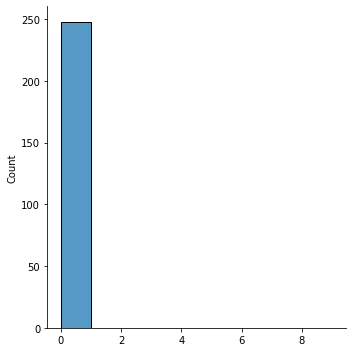

In [85]:
sns.displot(timing[1:] - timing[:-1], bins=range(10))

## FFT from soundecology

Load the FFT produced by the [`spectro`](https://rdrr.io/cran/seewave/man/spectro.html) function of the [`seewave`](https://rdrr.io/cran/seewave/) R package, which is used by [`soundecology`](https://rdrr.io/cran/soundecology/)'s [`acoustic_complexity`](https://rdrr.io/cran/soundecology/man/acoustic_complexity_index.html) function from CSV. Also load the timing CSV file produced.

These files are produced by the `generate_spectrogram_using_spectro.Rmd` file.

In [86]:
soundeco_spec = np.genfromtxt('soundecology_spectro_norm_6.csv', delimiter=',')
soundeco_spec = np.flip(soundeco_spec[1:,1:], axis=0)
soundeco_spec = soundeco_spec[:,:250]

In [87]:
timing_soundeco = np.genfromtxt('soundecology_spectro_norm_times_6.csv', delimiter=',')
timing_soundeco = timing_soundeco[1:,1:].reshape(-1)

Check spectrogram shapes.

In [88]:
bait_spec.shape, soundeco_spec.shape

((128, 250), (128, 250))

# Initial Spectrogram Comparison

Visualizes the spectrograms from BAIT (first) and `spectro` (second). The results are pretty similar on the whole. 

### BAIT

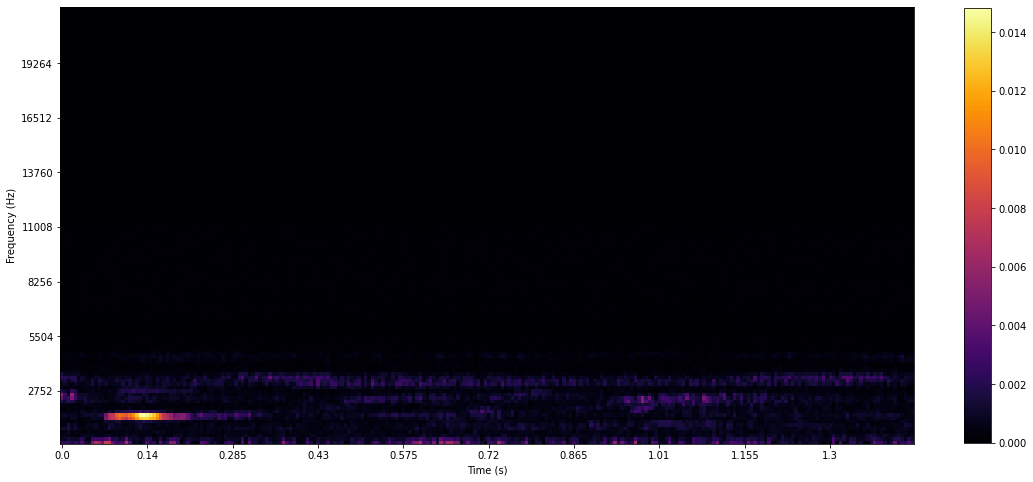

In [118]:
fig, ax = plt.subplots(figsize=(18, 16))
ticks = range(0, 250, 25)
ax.set_xticks(ticks)
ax.set_xticklabels(timing[ticks])
ax.set_yticks(range(128,0,-16))
ax.set_yticklabels(range(0,128*172,16*172))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.imshow(bait_spec[:,:], norm=plt.Normalize(), aspect=1, cmap=cmap)
plt.colorbar(fraction=0.1, shrink=0.5, aspect=16)

### `Spectro`

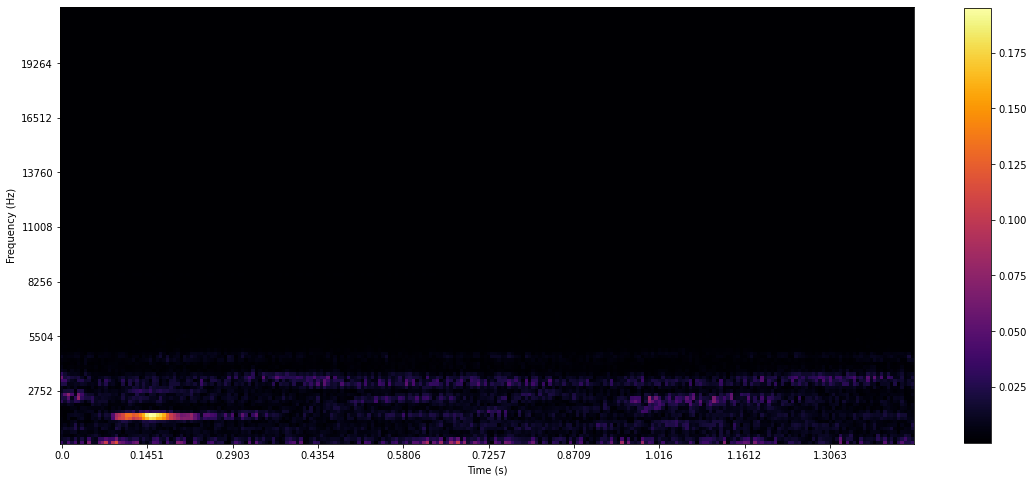

In [117]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(18, 16))
ax.set_xticks(range(0, 250, 25))
ax.set_xticklabels(np.round(timing_soundeco[range(0, 250, 25)], decimals=4))
ax.set_yticks(range(128,0,-16))
ax.set_yticklabels(range(0,128*172,16*172))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.imshow(soundeco_spec, norm=plt.Normalize(),aspect=1, cmap=cmap)
plt.colorbar(fraction=0.1, shrink=0.5, aspect=16)

# Normalization

The spectrograms look similar, but note that the range of values is quite different. To compare them, they must first be normalized.

In [174]:
bait_spec_norm = bait_spec / np.linalg.norm(bait_spec)
soundeco_spec_norm = soundeco_spec / np.linalg.norm(soundeco_spec)

spectro_values_df = pd.concat(
    [
      pd.DataFrame(data={
        'value': pd.Series(bait_spec.reshape(-1)),
        'source': 'bait'
      }),
      pd.DataFrame(data={
        'value': pd.Series(soundeco_spec.reshape(-1)),
        'source': 'soundecology'
      })
    ])
spectro_values_df_norm = pd.concat(
    [
      pd.DataFrame(data={
        'value': pd.Series(bait_spec_norm.reshape(-1)),
        'source': 'bait_norm'
      }),
      pd.DataFrame(data={
        'value': pd.Series(soundeco_spec_norm.reshape(-1)),
        'source': 'soundecology_norm'
      }),
    ])

Original distributions

<AxesSubplot:xlabel='value', ylabel='Count'>

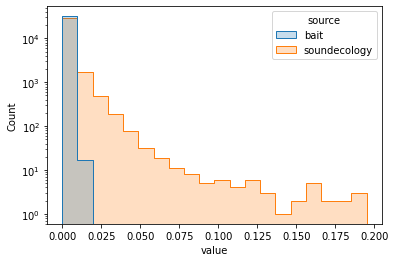

In [175]:
sns.histplot(spectro_values_df, x='value', hue='source', bins=20, log_scale=(False,True), element='step')

Normalized distribution

<AxesSubplot:xlabel='value', ylabel='Count'>

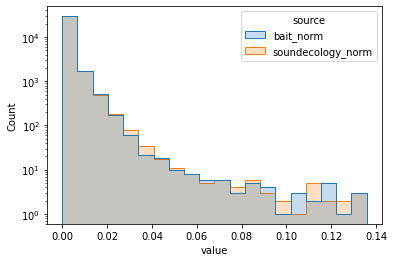

In [176]:
sns.histplot(spectro_values_df_norm, x='value', hue='source', bins=20, log_scale=(False,True), element='step')

# Subtraction

The normalized spectrograms can be substracted to visualize the difference between the two histograms.

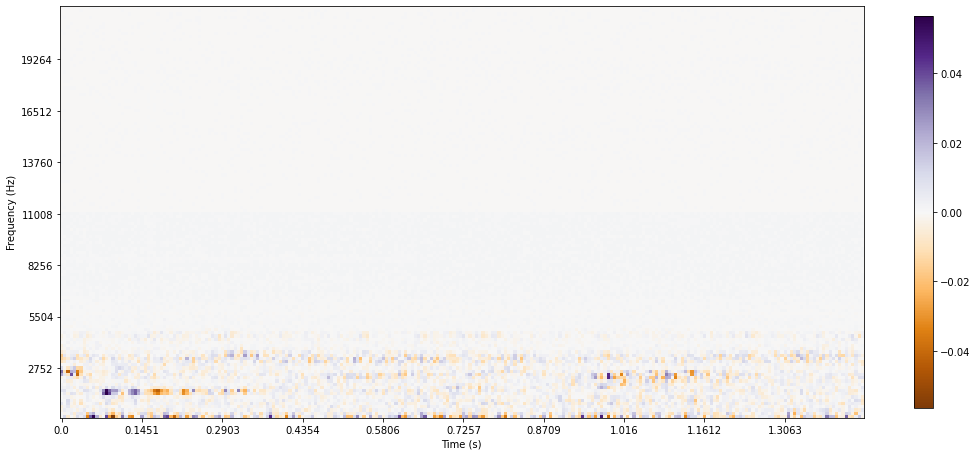

In [154]:
difference = bait_spec_norm - soundeco_spec_norm

fig, ax = plt.subplots(figsize=(18, 16))
ax.set_xticks(range(0, 250, 25))
ax.set_xticklabels(np.round(timing_soundeco[range(0, 250, 25)], decimals=4))
ax.set_yticks(range(128,0,-16))
ax.set_yticklabels(range(0,128*172,16*172))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.imshow(difference, norm=mcolors.CenteredNorm(), cmap='PuOr')
plt.colorbar(shrink=0.45)

Note that there seems to be a slight time misalignment in the plot. Positive difference values are followed by negative ones a couple of frames later.

A time offset of 2 frames was found to better align the signals to show the true difference between the FFTs. Note that there are still some pretty significant differences in the lower frequencies.

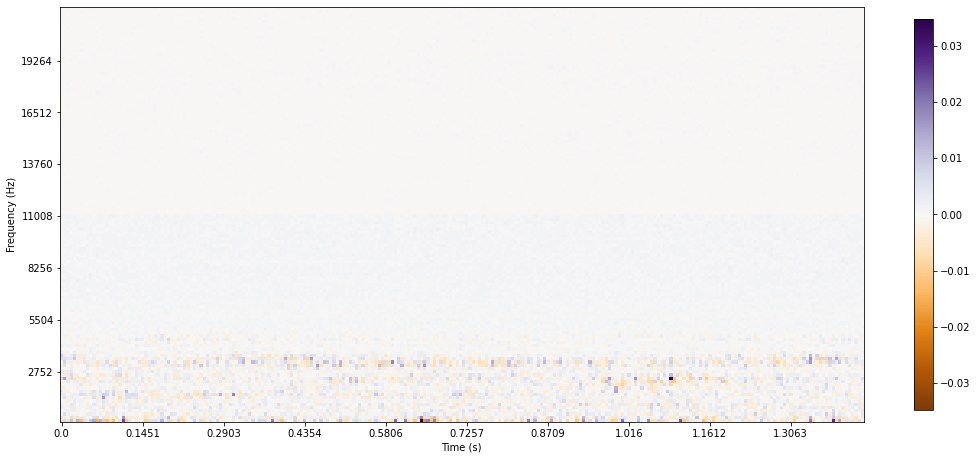

In [155]:
offset = 2 # The spectrograms are not exactly aligned

adj_difference = bait_spec_norm[:,:-offset] - soundeco_spec_norm[:,offset:]

fig, ax = plt.subplots(figsize=(18, 16))
ax.set_xticks(range(0, 250, 25))
ax.set_xticklabels(np.round(timing_soundeco[range(0, 250, 25)], decimals=4))
ax.set_yticks(range(128,0,-16))
ax.set_yticklabels(range(0,128*172,16*172))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.imshow(adj_difference, norm=mcolors.CenteredNorm(), cmap='PuOr')
plt.colorbar(shrink=0.45)

# Publication Image

Here, all of the work above is compiled into a single graph used in the publication.

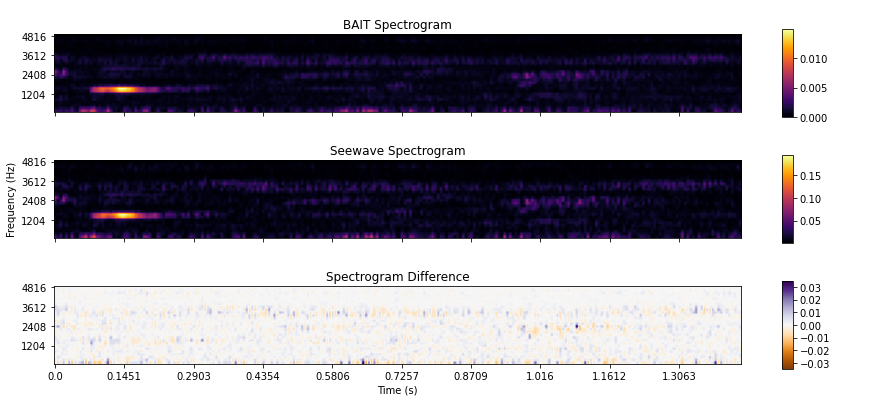

In [156]:
f, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(12.5,6))
plt.xlabel('Time (s)')
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax2.set_ylabel('Frequency (Hz)')

fraction, shrink, aspect = 0.1, 0.7, 8

ticks = range(0, 250, 50)
ax1.set_xticks(ticks)
ax1.set_xticklabels(timing[ticks])
ax1.set_yticks(range(0,28,7))
ax1.set_yticklabels(range(28*172,0,-7*172))
bait_img = ax1.imshow(bait_spec[100:,:-offset], norm=plt.Normalize(), cmap=cmap)
fig.colorbar(bait_img, ax=ax1, use_gridspec=True, fraction=fraction, shrink=shrink, aspect=aspect)
ax1.set_title('BAIT Spectrogram')

ax2.set_xticks(range(0, 250, 25))
ax2.set_xticklabels(np.round(timing_soundeco[range(0, 250, 25)], decimals=4))
se_image = ax2.imshow(soundeco_spec[100:,offset:], norm=plt.Normalize(), cmap=cmap)
fig.colorbar(se_image, ax=ax2, use_gridspec=True, fraction=fraction, shrink=shrink, aspect=aspect)
ax2.set_title('Seewave Spectrogram')


ax3.set_xticks(range(0, 250, 25))
ax3.set_xticklabels(np.round(timing_soundeco[range(0, 250, 25)], decimals=4))
diff_img = ax3.imshow(adj_difference[100:,:], norm=mcolors.CenteredNorm(), cmap='PuOr')
fig.colorbar(diff_img, ax=ax3, use_gridspec=True, fraction=fraction, shrink=shrink, aspect=aspect)
ax3.set_title('Spectrogram Difference')

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.savefig('spectrograms.pdf')